In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz

### Brief Exploration of Dataset

At 15 samples per rat with 72 rats, there are a total number of 1080 samples. 34 of the rats are trisomic, and 38 are normal. 

In [2]:
df = pd.read_csv("Data_Cortex_Nuclear.csv")
df.replace('', np.nan)
print(f'Number of samples: {df.shape[0]}')
print(f'Number of raw variables: {df.shape[1]}')

print(f'  - Number of numerical variables: {len(df._get_numeric_data().columns)}')
print(f'  - Categorical variables: {list(set(df.columns) - set(df._get_numeric_data().columns))}')
print(f'  - Number of null/empty values: {np.shape(np.where(pd.isnull(df)))[1]}\n')
print(f'Numerical variables with correlation coeff > 0.9')
corr_matrix = df._get_numeric_data().corr()
for r in range(np.shape(corr_matrix)[0]):
    for c in range(r, np.shape(corr_matrix)[1]):
        if(r != c and np.abs(corr_matrix.iat[r, c]) > 0.9):
            print(f'  - Columns: {corr_matrix.columns[r]}, {corr_matrix.columns[c]} | Correlation: {corr_matrix.iat[r, c]}')
print(f'\nNumber of rats: {df.shape[0]/15:.0f}')
tmp = df.loc[df['Genotype'] == 'Ts65Dn'].shape[0]
print(f'  - Number of trisomic rats: {tmp/15:.0f}')
print(f'  - Number of normal rats: {df.shape[0]/15 - tmp/15:.0f}')

Number of samples: 1080
Number of raw variables: 82
  - Number of numerical variables: 77
  - Categorical variables: ['class', 'MouseID', 'Genotype', 'Behavior', 'Treatment']
  - Number of null/empty values: 1396

Numerical variables with correlation coeff > 0.9
  - Columns: DYRK1A_N, ITSN1_N | Correlation: 0.959511771273714
  - Columns: DYRK1A_N, pERK_N | Correlation: 0.9457193906546549
  - Columns: DYRK1A_N, BRAF_N | Correlation: 0.9595779012202319
  - Columns: ITSN1_N, pERK_N | Correlation: 0.9062887297003324
  - Columns: ITSN1_N, BRAF_N | Correlation: 0.9176078424598713
  - Columns: NR1_N, pNR1_N | Correlation: 0.9478716685541191
  - Columns: NR1_N, Bcatenin_N | Correlation: 0.9146104019102185
  - Columns: pERK_N, BRAF_N | Correlation: 0.926984154241639
  - Columns: pNR1_N, pNR2B_N | Correlation: 0.9065036197767569
  - Columns: ARC_N, pS6_N | Correlation: 1.0

Number of rats: 72
  - Number of trisomic rats: 34
  - Number of normal rats: 38


### Pre-processing of Dataset

- Remove the "\_n" for MouseID column to allow for direct comparisons between mice
- Remove categorical labels that aren't 'MouseID' and 'Genotype' as we will not be using them for classification of mice
- Encode Trisomic (Genotype=T65DN) mice as 1, Normal (Genotype=Control) as -1
- Fill NaN values with the class-specific column mean

In [3]:
df['MouseID'].replace("\\_.*", "", inplace=True, regex=True)
df.drop(labels=['class', 'Behavior', 'Treatment'], axis=1, inplace=True)
df.replace("Ts65Dn", 1, inplace=True)
df.replace("Control", 0, inplace=True)
for label, series in df.items():
    if series.isnull().values.any():
        df[label] = df.groupby('Genotype').transform(lambda x: x.fillna(x.mean()))[label]

### Feature Extraction of Dataset
 - Using scikit-learn's PCA implementation, we reduced the dimensionality of our data matrix from 77 variables to just 27, while still capturing 99.5% of the energy in the data.
 - Reducing the dimensionality will greatly decrease the time taken for the classifiers to learn the decision boundary/tree.

In [4]:
pca = PCA(n_components=0.995, svd_solver='full')
data = pca.fit_transform(df.drop(labels=['Genotype', 'MouseID'], axis=1))
print(np.shape(data))

(1080, 27)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, df['Genotype'], test_size=0.33, random_state=1)
df_test = pd.DataFrame(X_test)
df_test['Genotype'] = list(y_test)

In [6]:
def make_plots(model, X_Train, y_train):
    n_classes = 2
    classes = ['Normal', 'Trisomic']
    plot_colors = ['blue', 'red']
    plot_step = 0.02
    for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
        X = X_train[:, pair]
        y = y_train

        # Train
        clf = model.fit(X, y)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, cmap='YlGn')

        plt.xlabel("PC" + str(pair[0]))
        plt.ylabel("PC" + str(pair[1]))
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color, label=classes[i], s=15)
        plt.legend(loc='lower right', borderpad=0, handletextpad=0)
        plt.show()
    return

### Processing of Dataset
1. LDA
 - Using sklearn's Linear Discriminant Analysis model
 - Learn a hyperplane which best linearly separates the data into two classes
 - Predict test data labels based on learned hyperplane
 - The displayed plots show the hyperplane that separates the two classes of data along two of the principal components, for visual reference. The actual quadratic surface learned for the data is higher in dimensionality and cannot easily be displayed.
2. QDA
 - Using sklearn's Quadratic Discriminant Analysis model
 - Learn a quadratic surface which best separates the data into two classes
 - Predict test data labels based on learned quadratic surface
 - The displayed plots show the quadratic surface that separates the two classes of data along two of the principal components, for visual reference. The actual quadratic surface learned for the data is higher in dimensionality and cannot easily be displayed.

#### Notes for graphs: The green shaded area represents the "Trisomic" decision region and the yellow shaded area represents the "Normal" decision region.

3. Decision Tree Classifier
 - Using sklearn's Decision Tree Classifier model
 - Recursively learn a decision tree where, given a test sample, you go along the decision tree, and classify the test sample as whichever leaf node you end up on.
 - Predict test labels via the above method
 - The displayed figure is the decision tree. Run the cell below the decision tree figure to save the figure as a PDF for easier reading!

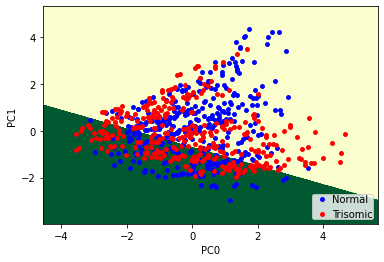

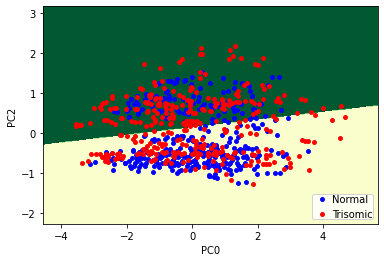

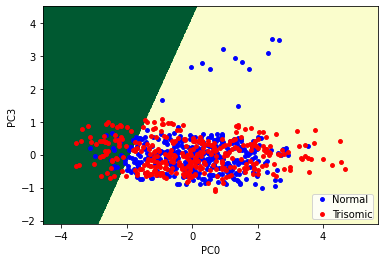

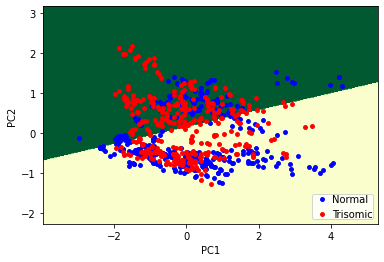

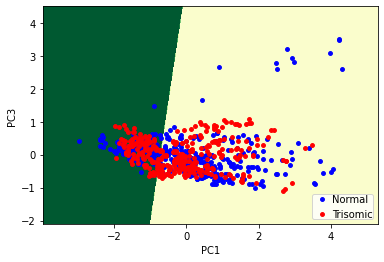

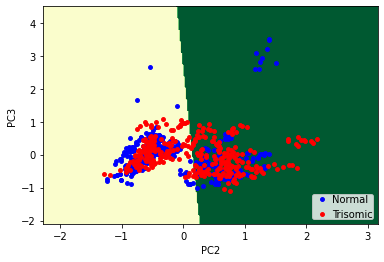

In [7]:
model = LDA()
make_plots(model, X_train, y_train)
model.fit(X_train, y_train)
labels = model.predict(X_test)
df_test['LDA'] = labels

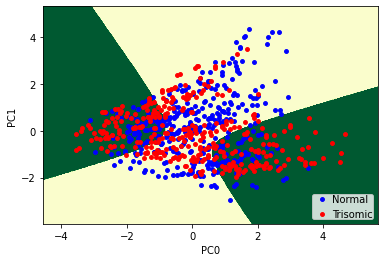

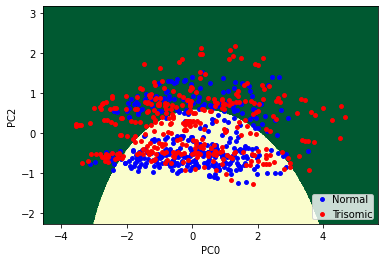

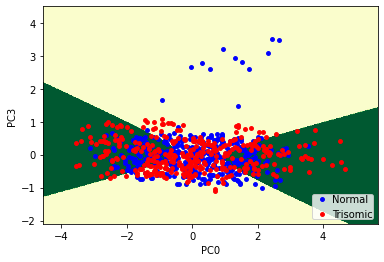

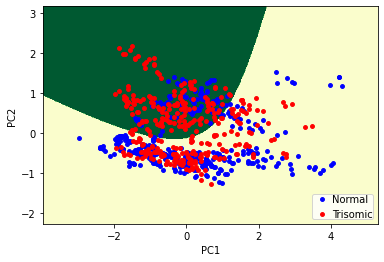

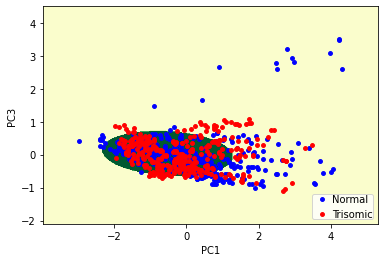

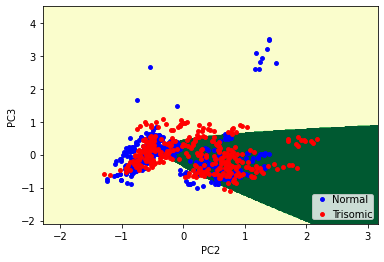

In [8]:
model = QDA()
make_plots(model, X_train, y_train)
model.fit(X_train, y_train)
labels = model.predict(X_test)
df_test['QDA'] = labels

In [9]:
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)
labels = model.predict(X_test)
df_test['DecisionTree'] = labels

### Run the below cell to export the decision tree to a PDF file for easier viewing!
* Be sure to install graphviz using either pip or conda package managers:
    * `pip3 install graphviz` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;or
    * `conda install python-graphviz`
* The PDF file will be exported to the current directory as `DecisionTree.pdf`

In [10]:
dot_data = tree.export_graphviz(model, out_file=None, filled=True,  impurity=False, class_names=['Normal', 'Trisomic']) 
graph = graphviz.Source(dot_data) 
graph.render('DecisionTree', view=False)
#graph

'DecisionTree.pdf'

### Comparitive Analysis

In [11]:
temp = df_test.loc[df_test['LDA'] == 1]
LDA_TP = len(temp.loc[temp['Genotype'] == 1])
LDA_FP = len(temp.loc[temp['Genotype'] == 0])
temp = df_test.loc[df_test['LDA'] == 0]
LDA_TN = len(temp.loc[temp['Genotype'] == 0])
LDA_FN = len(temp.loc[temp['Genotype'] == 1])

In [12]:
temp = df_test.loc[df_test['QDA'] == 1]
QDA_TP = len(temp.loc[temp['Genotype'] == 1])
QDA_FP = len(temp.loc[temp['Genotype'] == 0])
temp = df_test.loc[df_test['QDA'] == 0]
QDA_TN = len(temp.loc[temp['Genotype'] == 0])
QDA_FN = len(temp.loc[temp['Genotype'] == 1])

In [13]:
temp = df_test.loc[df_test['DecisionTree'] == 1]
DT_TP = len(temp.loc[temp['Genotype'] == 1])
DT_FP = len(temp.loc[temp['Genotype'] == 0])
temp = df_test.loc[df_test['DecisionTree'] == 0]
DT_TN = len(temp.loc[temp['Genotype'] == 0])
DT_FN = len(temp.loc[temp['Genotype'] == 1])

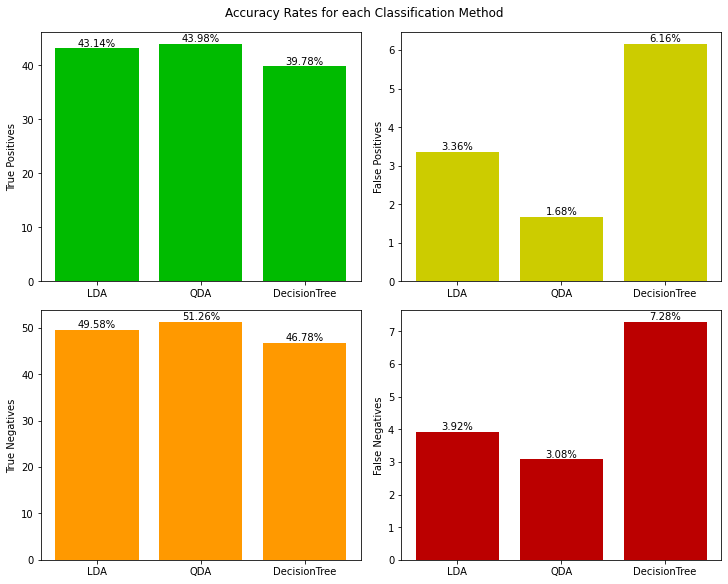

Number of test samples: 357
LDA Accuracy: 92.72%
QDA Accuracy: 95.24%
Decision Tree Accuracy: 86.55%


In [14]:
num_samples = df_test.shape[0]
def autolabel(rects, m, n):
    for rect in rects:
        height = rect.get_height()
        axs[m][n].text(rect.get_x() + rect.get_width()/2., 1*height, '%.2f' % float(height) + str("%"), ha='center', va='bottom')
        
fig, axs = plt.subplots(2, 2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Accuracy Rates for each Classification Method')
x = ['LDA', 'QDA', 'DecisionTree']
x_pos = [i for i, _ in enumerate(x)]

y = [LDA_TP / num_samples * 100, QDA_TP / num_samples * 100, DT_TP / num_samples * 100]
rects0 = axs[0][0].bar(x_pos, y, color="#00bb00")
axs[0][0].set_ylabel("True Positives")
y = [LDA_FP / num_samples * 100, QDA_FP / num_samples * 100, DT_FP / num_samples * 100]
rects1 = axs[0][1].bar(x_pos, y, color="#cccc00")
axs[0][1].set_ylabel("False Positives")
y = [LDA_TN / num_samples * 100, QDA_TN / num_samples * 100, DT_TN / num_samples * 100]
rects2 = axs[1][0].bar(x_pos, y, color="#ff9900")
axs[1][0].set_ylabel("True Negatives")
y = [LDA_FN / num_samples * 100, QDA_FN / num_samples * 100, DT_FN / num_samples * 100]
rects3 = axs[1][1].bar(x_pos, y, color="#bb0000")
axs[1][1].set_ylabel("False Negatives")

plt.setp(axs, xticks=[0, 1, 2], xticklabels=x)
autolabel(rects0, 0, 0)
autolabel(rects1, 0, 1)
autolabel(rects2, 1, 0)
autolabel(rects3, 1, 1)

plt.show()

print(f'Number of test samples: {num_samples}')
print(f'LDA Accuracy: {(LDA_TP + LDA_TN) * 100 / num_samples:.2f}%')
print(f'QDA Accuracy: {(QDA_TP + QDA_TN) * 100 / num_samples:.2f}%')
print(f'Decision Tree Accuracy: {(DT_TP + DT_TN) * 100 / num_samples:.2f}%')

Clearly, the QDA classifier outperforms both the LDA and Decision Tree classifiers in all four metrics. With an overall accuracy rate of 95.24%, it only misclassified 4.76% of the 357 (17) samples. For this classification task, the QDA classifier should go into production.

### Ethical Issues

In terms of ethical issues, since this protein expression data was collected from lab mice, few human-related ethical issues arise, assuming that the collection of the data was done humanely. However, extensive research and care should be taken before similar classification tasks are applied to humans or other animal species, or even other sets of mice, as this classification task was done for a very tightly controlled group of mice.

### Bibliography

Higuera C, Gardiner KJ, Cios KJ (2015) Self-Organizing Feature Maps Identify Proteins Critical to Learning in a Mouse Model of Down Syndrome. PLoS ONE 10(6): e0129126.

Higuera, Clara, et al. “Mice Protein Expression Data Set.” Archive.ics.uci.edu, National Science Foundation, 4 Aug. 2015, archive.ics.uci.edu/ml/. 

N/A, N/A. “Decision Trees.” Scikit, Scikit-Learn Developers, 2020, scikit-learn.org/stable/modules/tree.html. 

Varoquaux, Gaël, and Andreas Müller. “Classifier Comparison.” Edited by Jaques Grobler, Scikit-Learn, Scikit-Learn Developers, 2020, www.scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html.  